In [100]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np

# %matplotlib widget

In [101]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from slam.utils.transpiler_pass.weyl_decompose import (
    RootiSwapWeylDecomposition as decomposer,
)
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    Unroll3qOrMore,
    Optimize1qGates,
)
from slam.utils.gates.custom_gates import RiSwapGate
from qiskit.circuit.library import CXGate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator
from slam.basis import MixedOrderBasisCircuitTemplate
from slam.utils.polytopes.polytope_wrap import monodromy_range_from_target
from slam.utils.gates.family_extend import recursive_sibling_check
from slam.utils.gates.bare_candidates import get_group_name
from slam.utils.gates.duraton_scaling import cost_scaling, atomic_cost_scaling
from slam.utils.gates.winner_selection import pick_winner
from qiskit.transpiler.basepasses import AnalysisPass
from qiskit.transpiler.passes import CountOps
from qiskit.dagcircuit import DAGOpNode, DAGCircuit
from qiskit.transpiler import PassManager
from itertools import product

In [102]:
from slam.utils.circuit_suite import benchmark_lambdas

In [103]:
# load square-lattice coupling map or all-to-all
from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(8, 8)
coupling_map = CouplingMap.from_grid(3, 3)
# coupling_map = CouplingMap.from_full(16)

# load qiskit transpiler with pass for coupling map
induce_swaps = lambda qc: transpile(qc, coupling_map=coupling_map, optimization_level=3)

qc = benchmark_lambdas[3](9)
# turn off logging
logger.setLevel(logging.ERROR)
qc = induce_swaps(qc)
# turn back on logging
logger.setLevel(logging.INFO)

duration_1q = 0.1

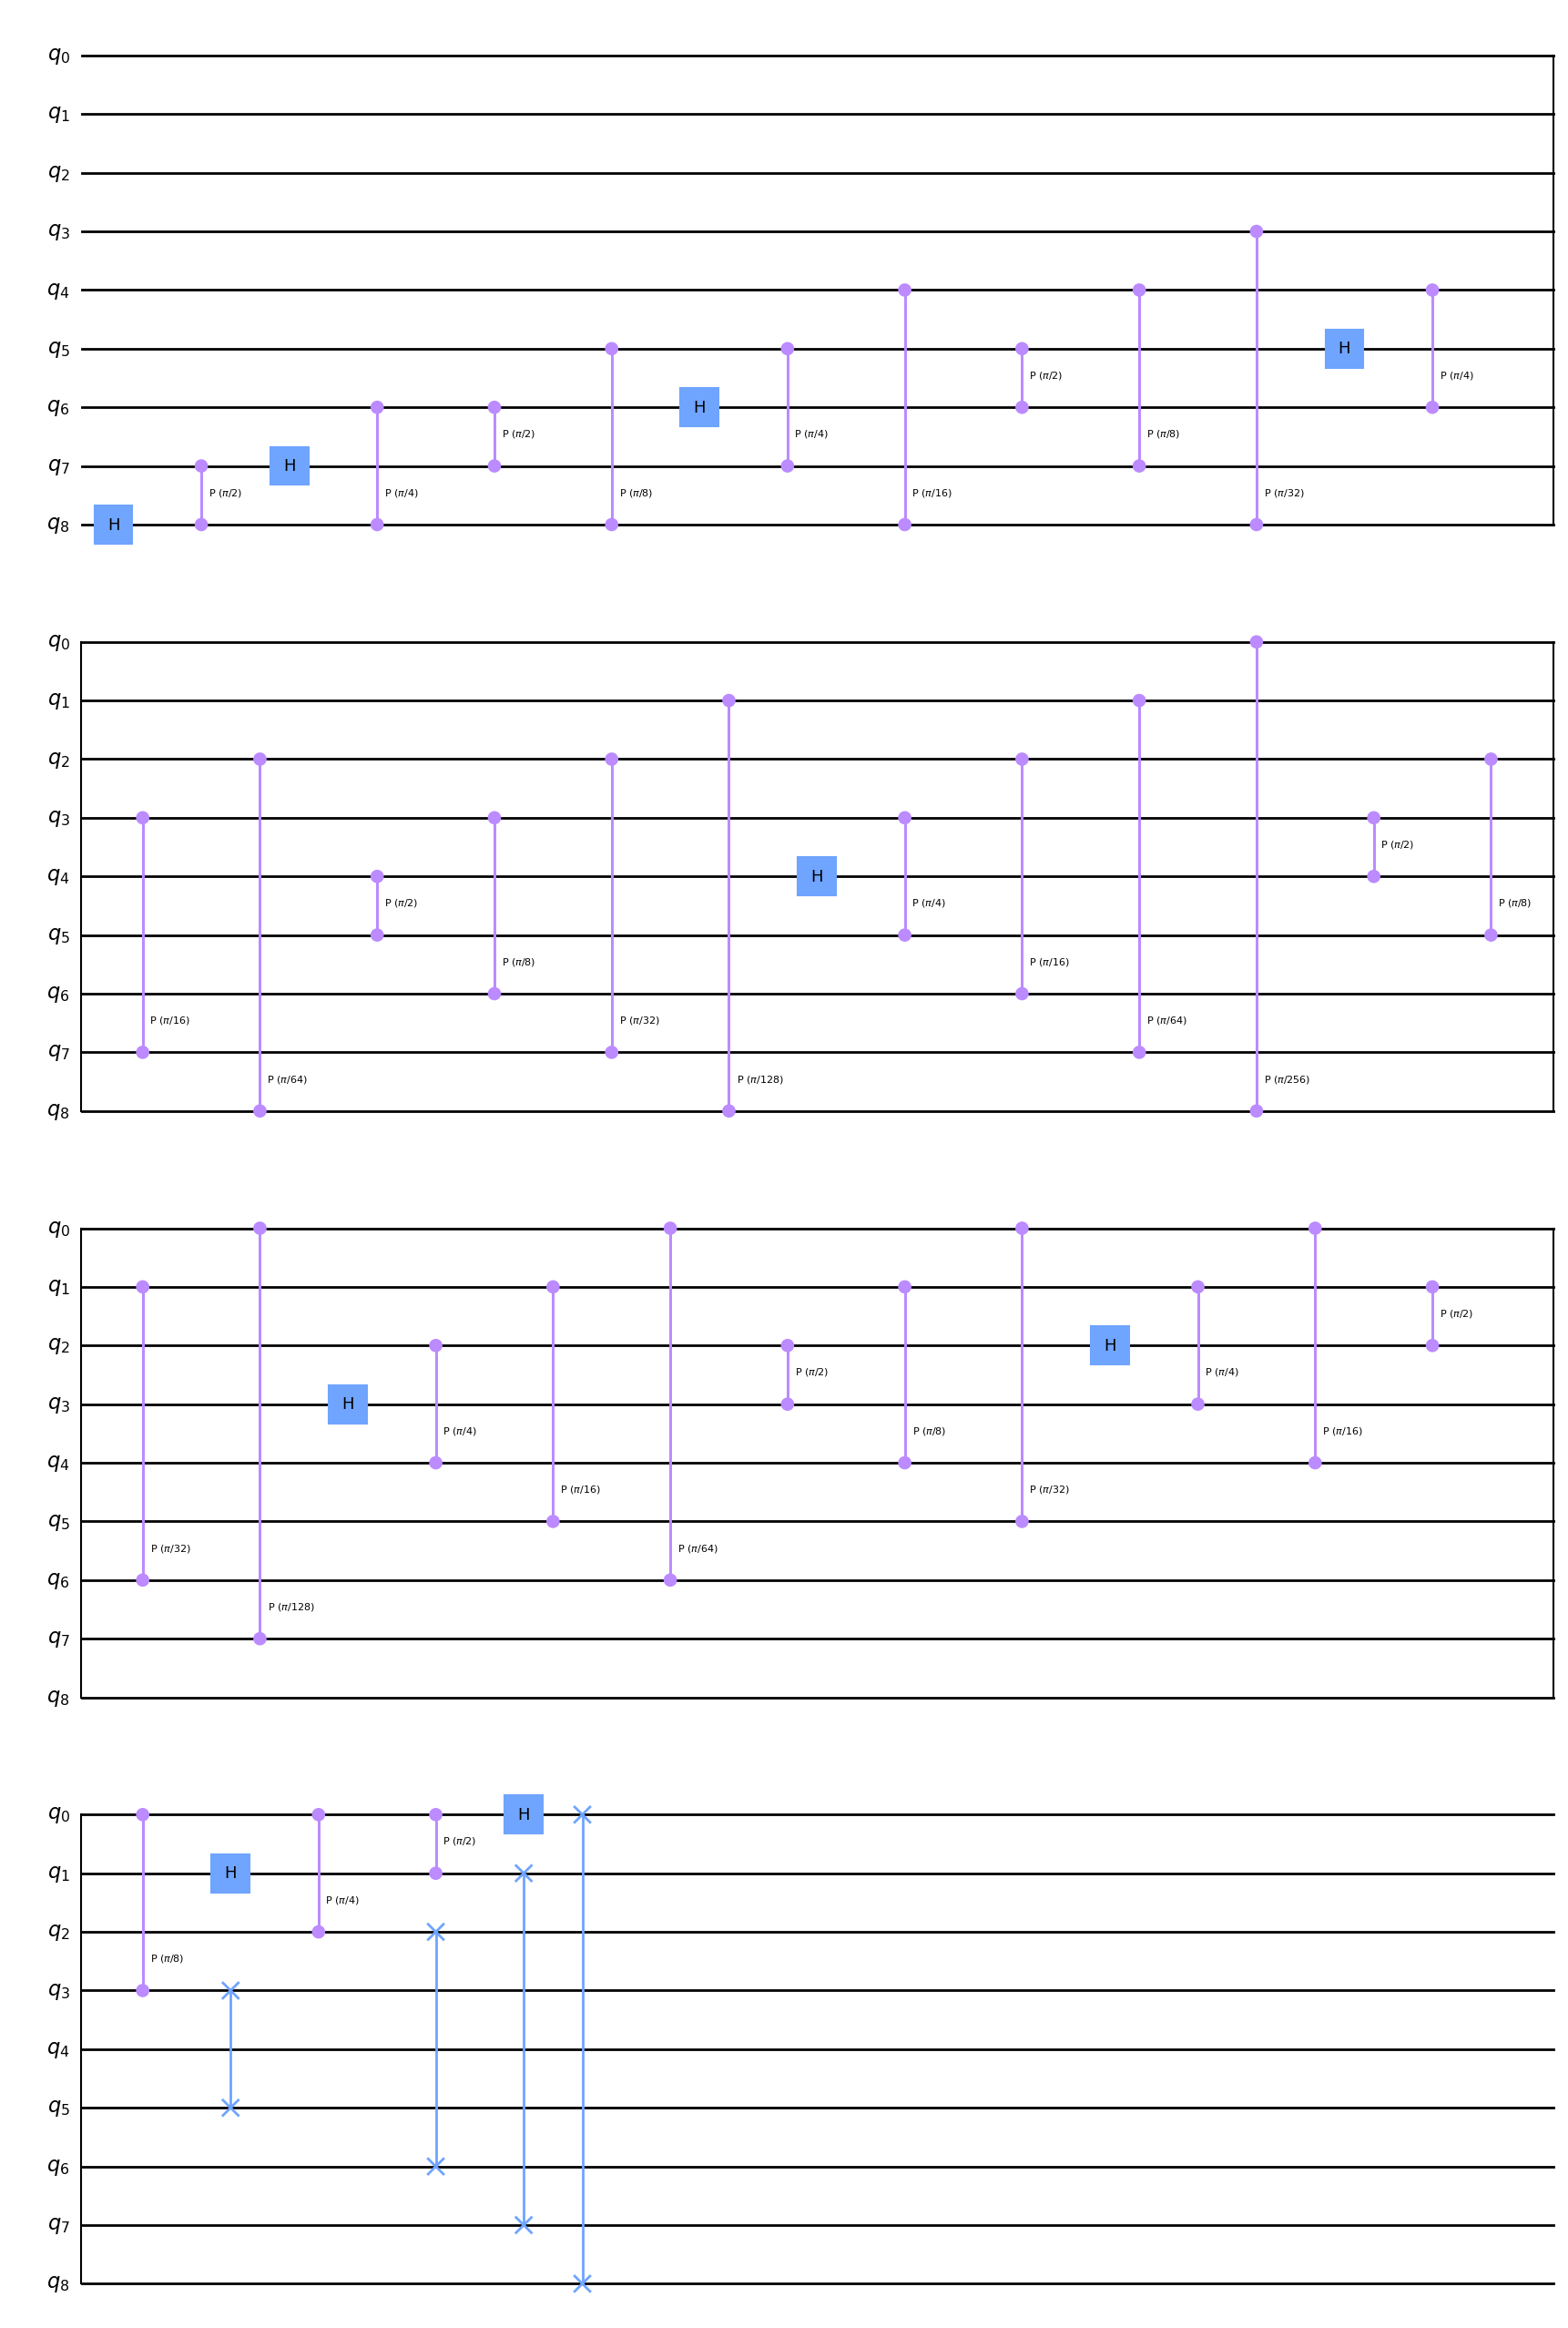

In [104]:
benchmark_lambdas[3](9).draw("mpl")

In [105]:
from slam.utils.transpiler_pass.speed_limit_pass import (
    pass_manager_basic,
    pass_manager_slam,
    pass_manager_optimized_sqiswap,
)

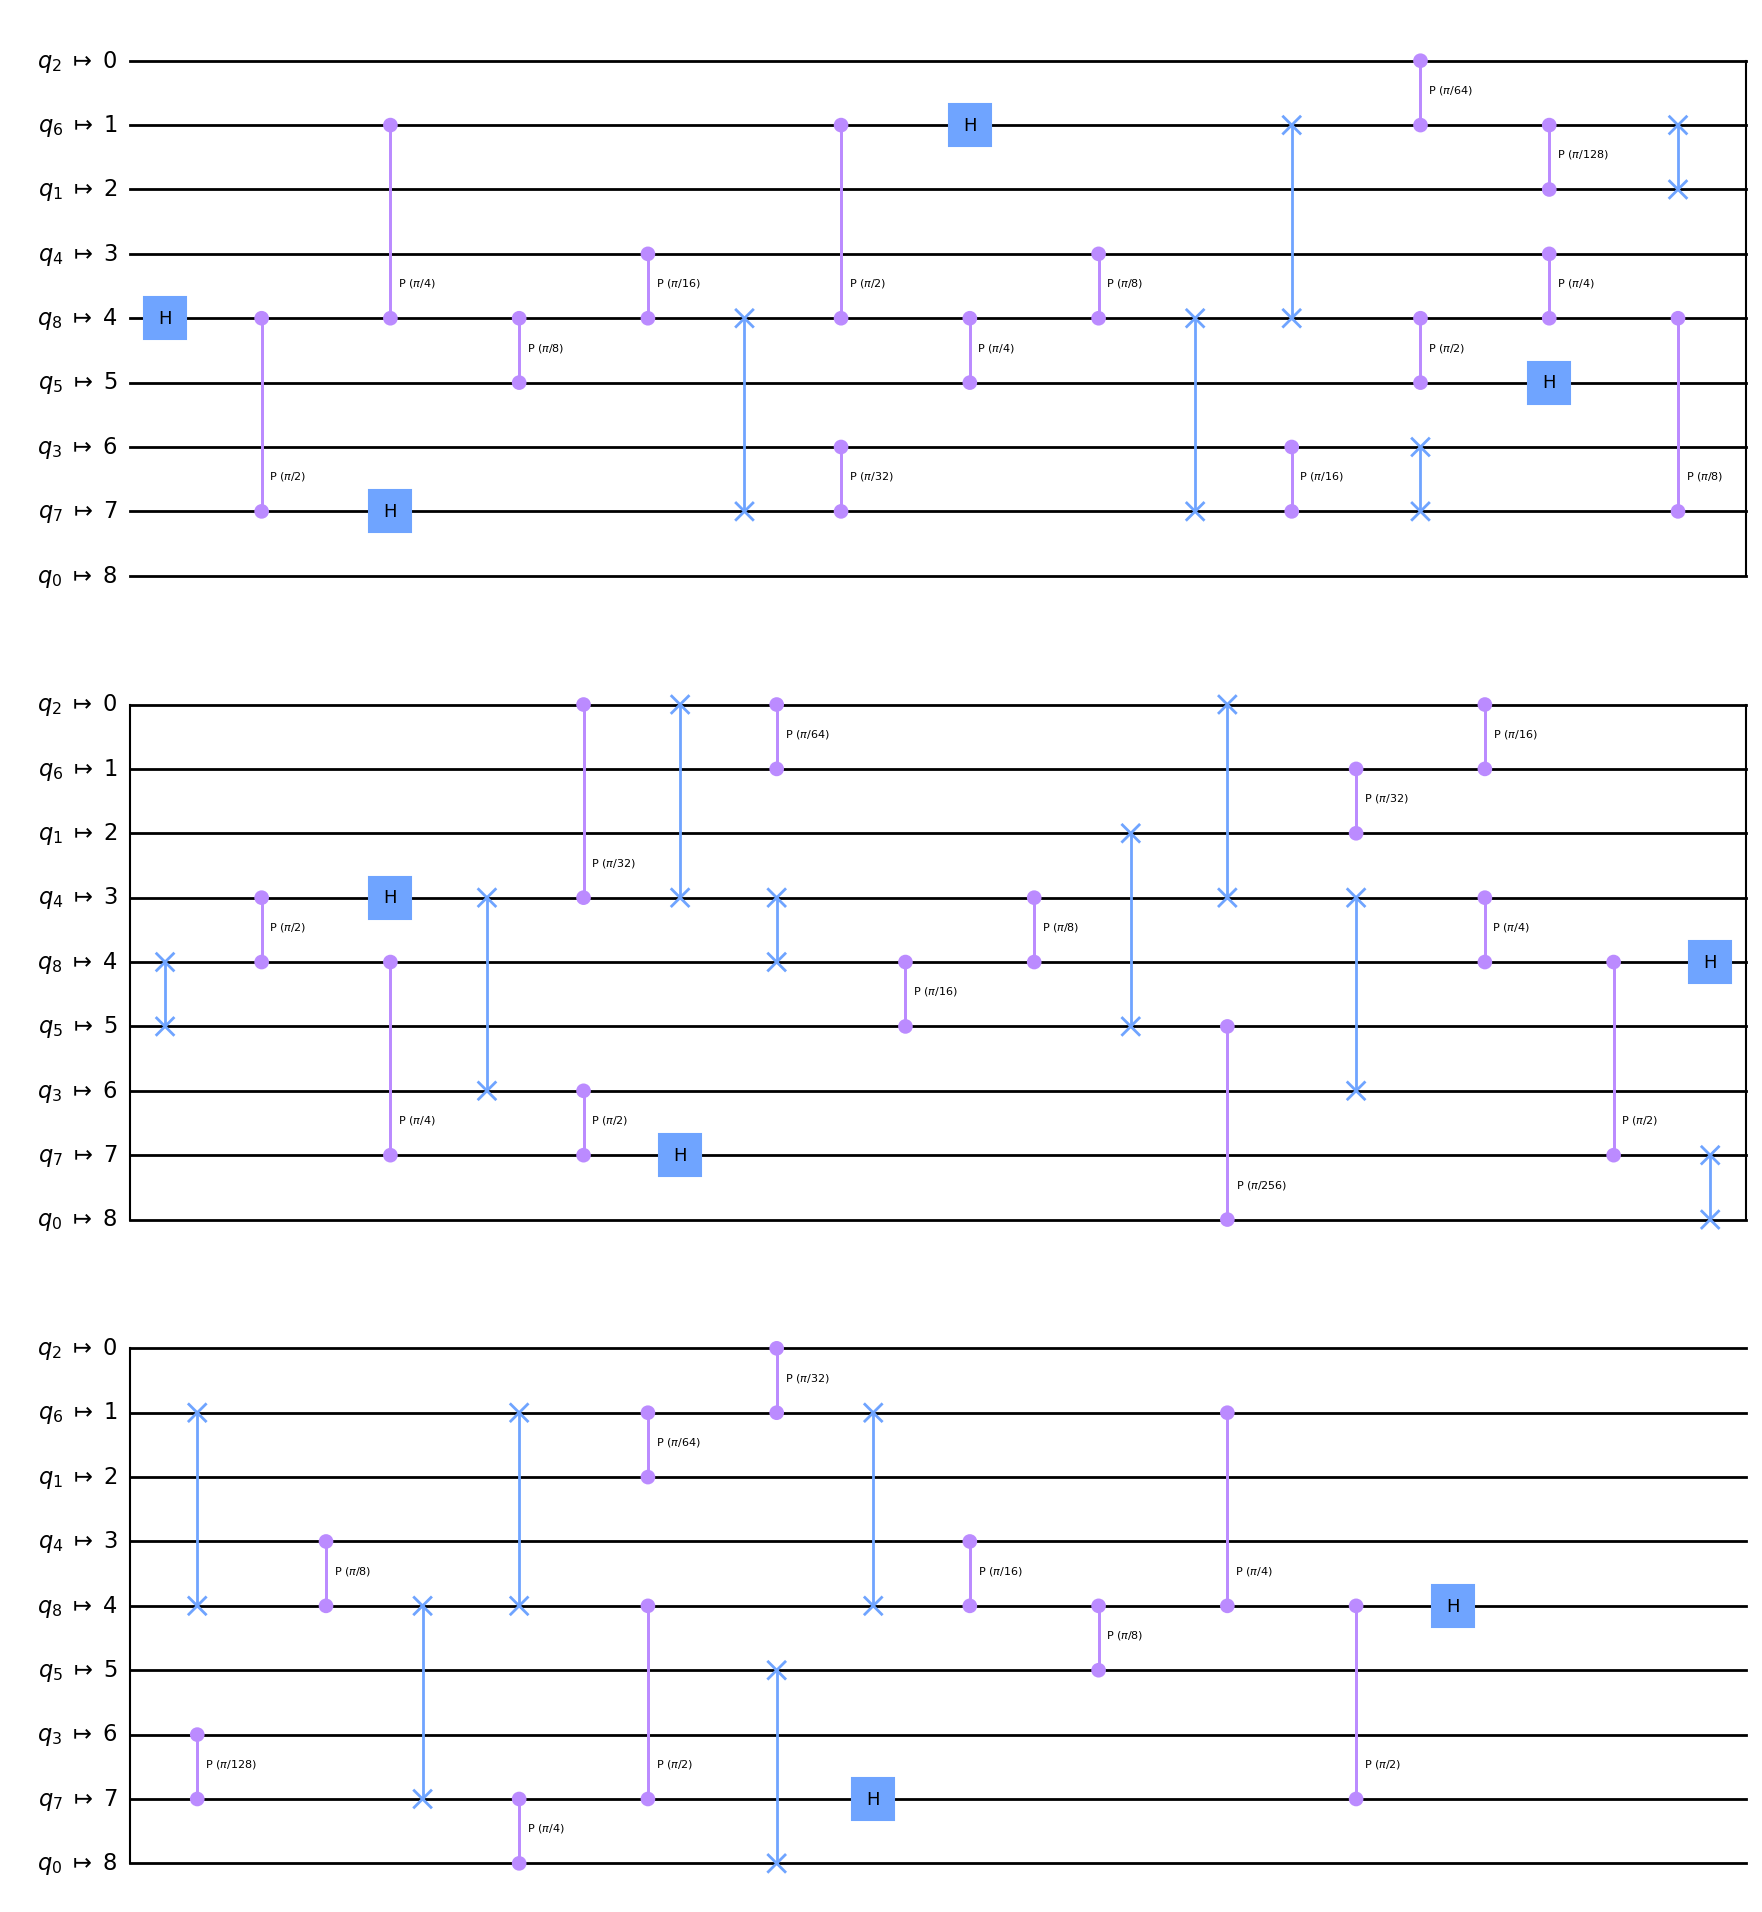

In [106]:
qc.draw("mpl")

(0.5, 0.5, 0.5)


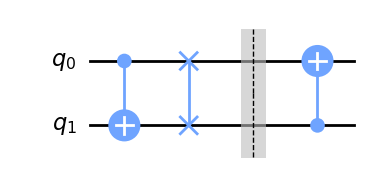

In [99]:
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.swap(0, 1)

qc.barrier()

qc.cx(1, 0)

# qc.swap(0,1)
# qc.h(1)
# qc.crz(np.pi/2, 0, 1)
# qc.h(0)


from weylchamber import c1c2c3

print(c1c2c3(Operator(qc).data))
qc.draw(output="mpl")

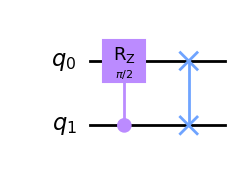

In [66]:
qc.draw("mpl")

In [76]:
pm = pass_manager_basic(gate="sqiswap", duration_1q=duration_1q)
transp1 = pm.run(qc)
# transp1.draw(output='mpl')

INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01192 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'crz': 1}
INFO:root:Longest Path Gate Counts: {'crz': 1}
INFO:root:Duration: 0
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 4.60458 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.01001 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.03219 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 0.93699 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RootiSwapWeylDecomposition - 11.19542 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 0.92030 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01335 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'u3': 3, 'riswap': 2, 'u2': 2, 'u1': 1}
INFO:root:Longest Path Gate Counts: {'u3': 2, 'riswap': 2, 'u2': 1}
INFO:root:Duration: 1.3
INFO:qiskit.transpiler.runningpassmanager:Pass

In [42]:
print(0.1 * 247 + 0.5 * 246)
print(0.1 * 5 + 1.9 * 45 + 1.3 * 56)

147.7
158.8


In [77]:
pm = pass_manager_optimized_sqiswap(duration_1q=duration_1q, speed_method="linear")
transp1 = pm.run(qc)
# transp1.draw(output='mpl')

INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01407 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'crz': 1}
INFO:root:Longest Path Gate Counts: {'crz': 1}
INFO:root:Duration: 0
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 3.98040 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.01836 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.05412 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 1.54185 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: OptimizedSqiswapSub - 6.87861 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 0.27800 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01788 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'2QGate(1.57079633, 0.00000000, 0.50000000)': 1, 'u3': 4}
INFO:root:Longest Path Gate Counts: {'u3': 2, '2QGate(1.57079633, 0.00000000, 0.50000000)': 1}
INFO:root:Duration: 0.7
INFO:qisk

In [8]:
method = ["linear", "mid", "squared", "hardware"][0]
strategy = ["basic_overall", "lambda_weight", "basic_smush", "lambda_smush"][3]
use_fam = 0
pm = pass_manager_slam(
    strategy=strategy,
    family_extension=use_fam,
    speed_method=method,
    duration_1q=duration_1q,
    coupling_map=coupling_map,
)
transp0 = pm.run(qc)
transp0.draw(output="mpl")

INFO:qiskit.transpiler.runningpassmanager:Pass: CountOps - 0.01097 (ms)
INFO:root:
Transpilation Results:
INFO:root:Gate Counts: {'cx': 1}
INFO:root:Longest Path Gate Counts: {'cx': 1}
INFO:root:Duration: 1
INFO:qiskit.transpiler.runningpassmanager:Pass: fooAnalysis - 4.13680 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroll3qOrMore - 0.01264 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Collect2qBlocks - 0.04101 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: ConsolidateBlocks - 1.11985 (ms)


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/evm9/decomposition_EM/data/cg_gates.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)